 ### Dataset
 **AqSolDB** - 9982 labelled datapoints of molecular structure (SMILES) and LogS, where S is in mol/L.
 Source: https://www.nature.com/articles/s41597-019-0151-1#Sec18

### Objectives in this notebook

- Inspect dataset, cleaning as necessary
- Convert molecules from InChI into graph representation
    - The whole point of this exercise is to build my own graph network, so I'll be doing this myself
- Define GNN architecture, converting graph network into a vectorized embedded representation

## Load and clean data

In [1]:
from SolGnn.config import project_root
import pandas as pd

data_path = project_root() / "data" / "curated-solubility-dataset.csv"
data = pd.read_csv(data_path)
data.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


We see that the authors gave us a few different ways to identify each molecule, it's solubility in water, and a number of molecular features.

I'll be building my own graph architecture and features, both through RDKit. So, all I need is the molecules' InChI, and solubility.

Additionally: while this dataset is primarily molecules, it includes a small number of crystalline materials (metals, oxides, other ceramics, salts, etc). These materials don't have a "molecular" structure in the same way small molecules do. You can absolutely build graph representations of inorganic crystals, but I am going to exclude these materials from my dataset from this project. Because of this difference in bonding, RDKit doesn't load these materials with any bonds. So, I'll take advantage of this to build my dataset.

In [2]:
from rdkit.Chem import MolFromInchi, AddHs

from SolGnn.data import inchi_to_mol
from SolGnn.config import project_root

data_path = project_root() / "data" / "curated-solubility-dataset.csv"
data = pd.read_csv(data_path, usecols = ["InChI", "Solubility"]) # just load the two columns I care about

len_before = len(data)
drop_list = []
for i in data.index:
    mol = inchi_to_mol(data.iloc[i]["InChI"]) # load as rdkit object
    if len(mol.GetBonds()) == 0: # check if the Mol has any bonds
        drop_list.append(i)
data.drop(drop_list, inplace = True) # and I get rid of the datapoints that won't be useful to ,e
len_after = len(data)

print(f"{len_before - len_after} molecules dropped")
print(f"{len_after} total datapoints")

cleaned_data_path = project_root() / "data" / "clean-dataset.csv"
data.to_csv(cleaned_data_path)

print(f"\nCleaned data saved to {cleaned_data_path.relative_to(cleaned_data_path.parents[-5])}")


148 molecules dropped
9834 total datapoints

Cleaned data saved to SolubilityGNN\data\clean-dataset.csv


## Splitting the dataset

I've implemented a Dataset object and loader to help load this cleaned data, and more importantly, split the dataset in a controlled manner. Let's look into that.

I've defined this ```SplitConfig``` class. This holds information about the ratios for my train/validation/test data split, as well as a seed for my random states. Default values are a 70/15/15 data split, and random state of 42. Implementing it this way will come in handy later, when I am evaluating the performance of various models and I won't have to worry about random variations in my dataset split!

In [3]:
from SolGnn.config import SplitConfig

split_config = SplitConfig()
split_config

SplitConfig(random_state=42, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

If not otherwise specified, get_dataset will load this default splitting configuration from my config files in the background.

In [4]:
from SolGnn.data import get_dataset
cleaned_data_path = project_root() / "data" / "clean-dataset.csv"
dataset = get_dataset(cleaned_data_path)

print(
    f"Training set size: {len(dataset.X_train)}\n"
    f"Validation set size: {len(dataset.X_valid)}\n"
    f"Test set size: {len(dataset.X_test)}"
)

Training set size: 6883
Validation set size: 1475
Test set size: 1476


## Defining a feature basis

In order to be able to easily run tests with different settings in my graph network, I need to be able to automatically generate my graphs with the specified node and edge features from some arbitrary dataset.

To do this, I have developed the FeatureBasis class. I wrote this object to be an "sklearn-like" data transformer, with a ```.fit()``` and ```.transform()``` method. This ```.fit()``` method is exactly why I have split my data above already. Much like when scaling data in supervised learning, I don't want to cause any dataleakage by fitting my preprocessors on data that might provide hints to the model as to what's to come.

Example: for a dataset of <1000 molecules such as ours, imagine there is a molecule containing a trimethylsilane group. Not a group all that common to organic molecules, but it's within the realm of possibility! Say it is randomly placed in our testing set. We plan to one-hot encode the identity of each atom (and maybe some other features) into our graphs. Should the model by tipped off that a silicon atom is coming during our testing phase? This has the potential to artificially make the model perform a little better than it would in production, when predicting properties of molecules that truely haven't been seen before. So, instead, this model will not have an open on-hot-encoding slot for these types of features.

Scaler features are scaled by Z-scaling (```sklearn.preprocessing.StandardScaler```) where

$$
Z = \frac{x-\mu}{\sigma}
$$

I am planning to play around with what node, edge and global features are included in my graph networks, so this object is instantiated with "feature specifications" that instruct the class on what features to build the graph with.

In [5]:
from rdkit.Chem.Descriptors import MolWt

from SolGnn.graphs import FeatureBasis, AtomFeatureSpec, BondFeatureSpec, GlobalFeatureSpec

#---------- Define my feature specifications -----
atom_spec = AtomFeatureSpec(
    one_hot=["GetSymbol"],
    scaled=["GetMass", "GetAtomicNum"]
)

bond_spec = BondFeatureSpec(
    one_hot=["GetBondTypeAsDouble"],
    scaled=[]
)

global_spec = GlobalFeatureSpec(
    scaled=[MolWt],
)

# ---------- instantiate FeatureBasis and train
basis = FeatureBasis(atom_spec, bond_spec, global_spec)
basis = basis.fit(dataset.X_train)

The data transformer is fitted, let's test it out and see if it is behaving as expected.

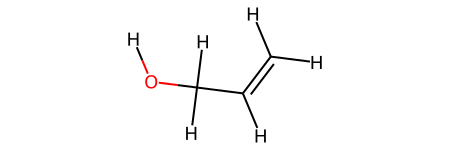

In [6]:
example_inchi = "InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2" # prop-1-en-1-ol
example_mol = inchi_to_mol(example_inchi)
example_mol

I count 10 atoms (nodes) and 9 bonds, which means there should be 18 edges for the undirected graph. There are three types of nodes (C, H, O) and two different types of edges (single and double bonds) Does the graph representations agree?

In [7]:
atom_features = basis.featurize_atoms(example_mol)           # (n_atoms, d_node)
edge_index, bond_features = basis.featurize_bonds(example_mol)
global_features = basis.featurize_global(example_mol)

print(f"Atom feature shape: {atom_features.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Bond features shape: {bond_features.shape}")
print(f"Global features shape: {global_features.shape}")

print("--------------------------------------\n Atom Features")
print(atom_features[0])

print("-----------------------------------------\n Edge Index")
print(edge_index)

print("-----------------------------------------\n Bond Features")
print(bond_features)

print("-----------------------------------------\nGlobal Features")
print(global_features)


Atom feature shape: (10, 54)
Edge index shape: (2, 18)
Bond features shape: (18, 4)
Global features shape: (1, 1)
--------------------------------------
 Atom Features
[0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.44846886 0.44810908]
-----------------------------------------
 Edge Index
[[0 1 1 2 2 3 0 4 0 5 1 6 2 7 2 8 3 9]
 [1 0 2 1 3 2 4 0 5 0 6 1 7 2 8 2 9 3]]
-----------------------------------------
 Bond Features
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0

It appears that the molecular graph was correctly rendered. Last step is to plug this information into the ```torch_geometric.data.Data``` format. That's demonstrated below, but now we can take this into the next notebook for model training.

In [8]:
basis.transform([example_inchi])

[Data(x=[10, 54], edge_index=[2, 18], edge_attr=[18, 4], global_feat=[1, 1])]

## Summary

I have a data transform that can be configured with RDKit to define node, edge and global features for a graph representation of molecules. The transformer can be "fitted" by feeding training data along with this configuration. This takes care of one-hot-encoding features, and scaling scalar features. After fitting, the transformer can take new InChI keys in, and output grapsh of molecules using the fitted basis. The data is output in the pytorch-geometric Data format for further use.